# Sample Points from COLMAP just relating to Image Number 100

In [1]:
from splat.read_colmap import read_images_text, qvec2rotmat
from splat.gaussians import Gaussians
from splat.gaussian_scene import GaussianScene
import pycolmap
import torch 
import torch.nn as nn
import numpy as np

from splat.utils import read_images_text, read_images_binary

colmap_path = "treehill/sparse/0"

reconstruction = pycolmap.Reconstruction(colmap_path)
test = False

points3d = reconstruction.points3D
images = read_images_binary(f"{colmap_path}/images.bin")
cameras = reconstruction.cameras

# we will only use points from image_num 100
image_num = 100
        
image = images[image_num]
points_in_3d = []
points2d = []
colors2d = []
for idx, point in enumerate(image.xys):
    point3d_id = image.point3D_ids[idx]
    if point3d_id > 0:
        try:
            color = points3d[point3d_id].color
            points_in_3d.append(points3d[point3d_id].xyz)
            points2d.append(point)
            colors2d.append(color)
        except:
            pass
        
points_in_3d = np.array(points_in_3d)
points2d = np.array(points2d)
colors2d = np.array(colors2d)

gaussians = Gaussians(
    torch.Tensor(points_in_3d), 
    torch.Tensor(colors2d),
    model_path="point_clouds"
)

# Plot their 2d location - this is what we will seek to recreate

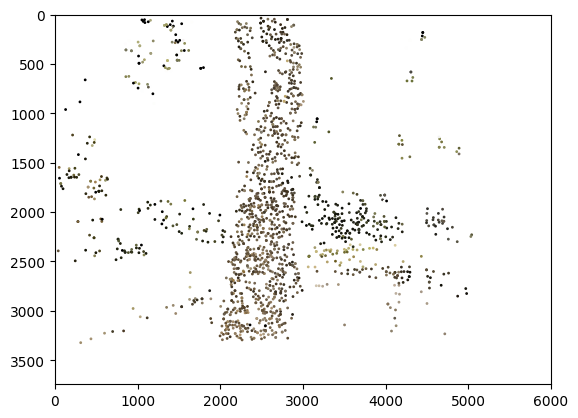

In [2]:
import matplotlib.pyplot as plt

scene = GaussianScene(
    colmap_path=colmap_path,
    gaussians=gaussians,
)

plt.scatter(points2d[:, 0], points2d[:, 1], c=colors2d / 256, s=1)
plt.xlim(0, 6000)
plt.ylim(0, 3744)
plt.gca().invert_yaxis() 

# Project points to 2d using the intrinsic and extrinsic matrices

torch.Size([1697, 3])


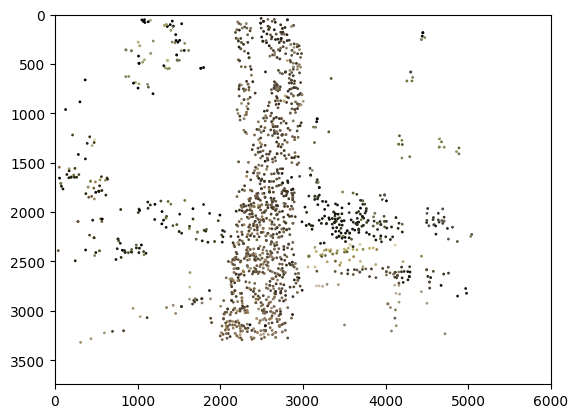

In [3]:
with torch.no_grad():
    points, colors = scene.render_points_image(image_num)

print(points.shape)
plt.scatter(points[:, 0].cpu(), points[:, 1].cpu(), c=colors.cpu(), s=1)
plt.xlim(0, 6000)
plt.ylim(0, 3744)
plt.gca().invert_yaxis() 

# Render Image with Gaussians

In [4]:
image = scene.render_image(image_num, tile_size = 2)


100%|██████████| 2533/2533 [00:42<00:00, 60.17it/s] 


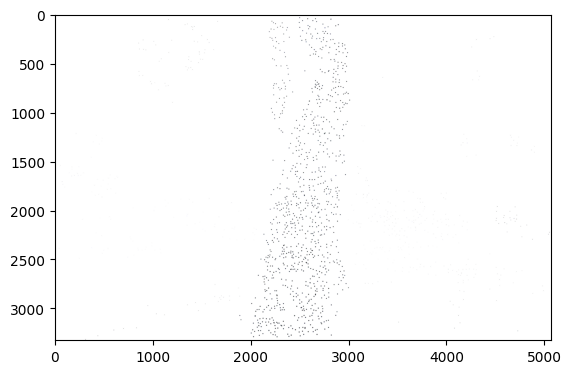

In [5]:
import matplotlib.pyplot as plt

# Assuming new_image is your image tensor

# Set background to white
new_image = image * (image > 0.001).float()
new_image[new_image <= 0.001] = 1

# Display the image
plt.imshow(new_image.detach().transpose(0, 1), cmap='gray', vmin=0, vmax=1)
plt.show()

In [6]:
# shows there are points in the white space that we just cannot see
image[:1000].max()

tensor(0.7134, grad_fn=<MaxBackward1>)

# Now we will render the whole scene

In [25]:
from splat.gaussians import Gaussians
from splat.gaussian_scene import GaussianScene
import pycolmap
import torch 
import torch.nn as nn
import numpy as np

from splat.utils import read_images_text, read_images_binary

colmap_path = "treehill/sparse/0"
reconstruction = pycolmap.Reconstruction(colmap_path)

points3d = reconstruction.points3D

all_points3d = []
all_point_colors = []

for idx, point in enumerate(points3d.values()):
    if point.track.length() >= 2:
        all_points3d.append(point.xyz)
        all_point_colors.append(point.color)

gaussians = Gaussians(
    torch.Tensor(all_points3d), 
    torch.Tensor(all_point_colors),
    model_path="point_clouds"
)
scene = GaussianScene(
    colmap_path=colmap_path,
    gaussians=gaussians,
)

# Renders all points in the scene with our projection matrices

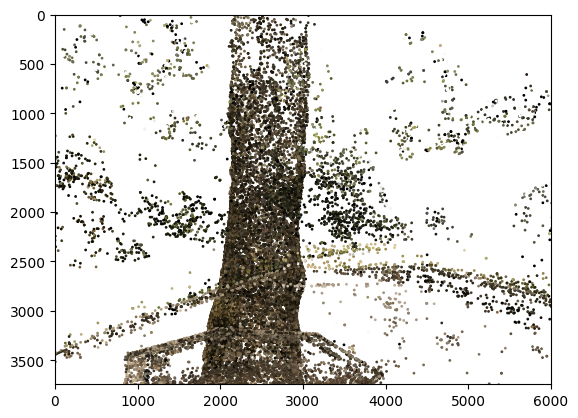

In [8]:
from matplotlib import pyplot as plt
image_num = 100

processed_scene = scene.preprocess(image_num)
plt.scatter(processed_scene.points_xy[:, 0].detach().cpu(), processed_scene.points_xy[:, 1].detach().cpu(), c=processed_scene.colors.detach().cpu(), s=1)
plt.xlim(0, 6000)
plt.ylim(0, 3744)
plt.gca().invert_yaxis() 

# Uses our rendering engine to render pixel by pixel

100%|██████████| 316/316 [05:43<00:00,  1.09s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


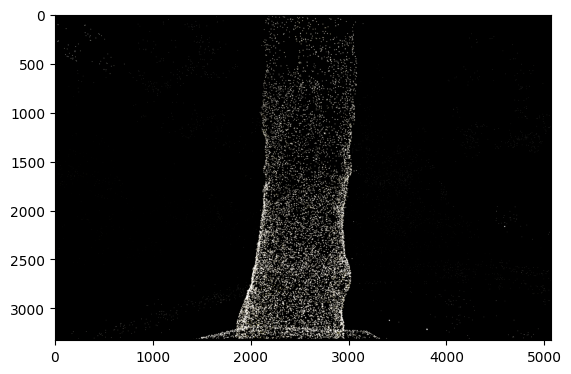

In [9]:
# this may take a while

with torch.no_grad():
    image = scene.render_image(image_num)

plt.imshow(image.cpu().detach().transpose(0, 1) * 256)